In [141]:
%matplotlib inline
# import environment and expose in jupyter env
# this only works when shellvars is installed as it is in L-CAS Juptyer images
# https://github.com/LCAS/jupyterhub-deploy-docker/blob/master/singleuser/Dockerfile#L100

import shellvars
from os import environ

def loadenv(filename='/opt/ros/kinetic/setup.bash'):
    vs = shellvars.get_vars(filename)
    for v in vs:
        print('%s=%s' % (v.decode("utf-8"), str(vs[v].decode("utf-8"))))
        environ[v.decode("utf-8")] = str(vs[v].decode("utf-8"))

loadenv()

# clean up sys path and add new paths from environ

import sys

# add system path

sys.path.append('/opt/conda/envs/python2/lib/python2.7/site-packages')
sys.path.append('/opt/conda/envs/python2/lib/python2.7/site-packages/scipy/signal/')
sys.path.append('/usr/lib/python2.7/dist-packages')


pp = environ['PYTHONPATH'].split(':')

sys.path = pp + sys.path 
new_sys_path = []
for p in sys.path:
    if p != '':
        if p not in new_sys_path:
            new_sys_path.append(p)
        
sys.path = new_sys_path

import rosbag_pandas

ROS_DISTRO=kinetic
PYTHONPATH=/opt/ros/kinetic/lib/python2.7/dist-packages
ROS_ETC_DIR=/opt/ros/kinetic/etc/ros
ROS_ROOT=/opt/ros/kinetic/share/ros
ROS_MASTER_URI=http://localhost:11311
ROS_VERSION=1
ROS_PACKAGE_PATH=/opt/ros/kinetic/share
PKG_CONFIG_PATH=/opt/ros/kinetic/lib/pkgconfig
PATH=/opt/ros/kinetic/bin:/opt/conda/envs/python2/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
CMAKE_PREFIX_PATH=/opt/ros/kinetic
LD_LIBRARY_PATH=/opt/ros/kinetic/lib
/opt/conda/envs/python2/lib/python2.7/site-packages/rosbag_pandas.pyc


In [140]:
import numpy as np
def load_data(bagfile):
    # values in cov:
    # 0: xx
    # 1: xy
    # 6: yx
    # 7: yy
    data = rosbag_pandas.bag_to_dataframe(bagfile, include=['/amcl_pose'])
    data['cov_xx'] = data[u'amcl_pose__pose_covariance0']
    data['cov_xy'] = data[u'amcl_pose__pose_covariance1']
    data['cov_yx'] = data[u'amcl_pose__pose_covariance6']
    data['cov_yy'] = data[u'amcl_pose__pose_covariance7']
    print(data.columns)
    data = data.filter(regex=("cov_[xy][xy]"))
    return data

good_data = load_data('good_operation_1_2019-07-18-09-59-35.bag')
bad_data = load_data('bad_operation_1_2019-07-18-10-02-02.bag')


Index([u'amcl_pose__pose_covariance0', u'amcl_pose__pose_covariance1',
       u'amcl_pose__pose_covariance10', u'amcl_pose__pose_covariance11',
       u'amcl_pose__pose_covariance12', u'amcl_pose__pose_covariance13',
       u'amcl_pose__pose_covariance14', u'amcl_pose__pose_covariance15',
       u'amcl_pose__pose_covariance16', u'amcl_pose__pose_covariance17',
       u'amcl_pose__pose_covariance18', u'amcl_pose__pose_covariance19',
       u'amcl_pose__pose_covariance2', u'amcl_pose__pose_covariance20',
       u'amcl_pose__pose_covariance21', u'amcl_pose__pose_covariance22',
       u'amcl_pose__pose_covariance23', u'amcl_pose__pose_covariance24',
       u'amcl_pose__pose_covariance25', u'amcl_pose__pose_covariance26',
       u'amcl_pose__pose_covariance27', u'amcl_pose__pose_covariance28',
       u'amcl_pose__pose_covariance29', u'amcl_pose__pose_covariance3',
       u'amcl_pose__pose_covariance30', u'amcl_pose__pose_covariance31',
       u'amcl_pose__pose_covariance32', u'amcl_pose__po

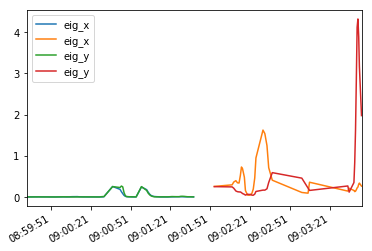

In [46]:

import matplotlib.pyplot as plt


def cov_analysis(df):
    def __cov(r):
        m = np.mat([
            [r['cov_xx'], r['cov_xy']],
            [r['cov_yx'], r['cov_yy']]
        ])
        e = np.linalg.eig(m)
        #print(e[0])
        r['eig_x'] = e[0][0]
        r['eig_y'] = e[0][1]
        r['eig_mag'] = np.sqrt(e[0][0]*e[0][0] + e[0][1]*e[0][1])
        return r
    
    df = df.apply(
        __cov,
        axis=1,
    )
    return df

gd = cov_analysis(good_data)
bd = cov_analysis(bad_data)
gd['eig_x'].plot()
bd['eig_x'].plot()
gd['eig_y'].plot()
bd['eig_y'].plot()
plt.legend()
#display(good_data.columns)

-0.37621602315015495
0.044149295581219605
-0.3788371436251382
0.0183857900270345


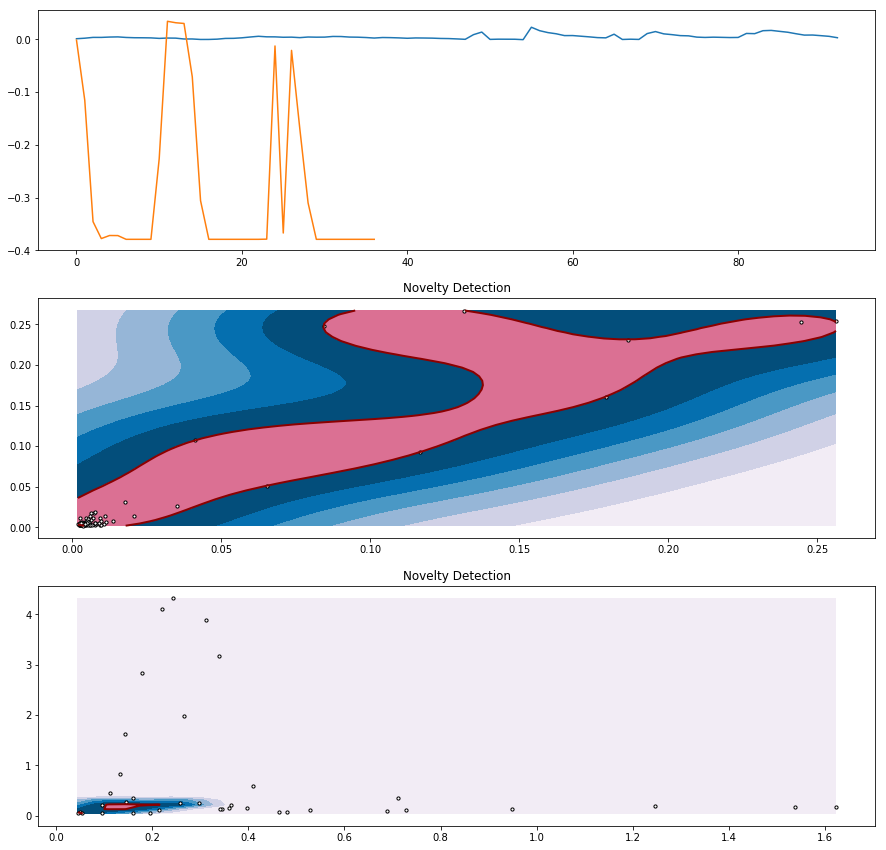

In [126]:
from sklearn import svm
def train_svm(df, nu=.2):
    cx = df['eig_x'].values
    cy = df['eig_y'].values
    data = np.array([cx.tolist(), cy.tolist()]).transpose()
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=(1/(data.shape[1] * data.var())))
    clf.fit(data)
    return clf, data

def display_svm(clf, data):
    xx, yy = np.meshgrid(np.linspace(np.min(data[:,0]), np.max(data[:,0]), 50), np.linspace(np.min(data[:,1]), np.max(data[:,1]), 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.rcParams['figure.figsize'] = [15, 15]

    plt.title("Novelty Detection")
    s=10
    print(Z.min())
    print(Z.max())
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    plt.scatter(data[:, 0], data[:, 1], c='white', s=s, edgecolors='k')

def svm_predict(clf, data):
    return clf.decision_function(data)
    
good_clf, g_data = train_svm(gd, .02)
bad_clf, b_data = train_svm(bd, .02)
g_scores = svm_predict(good_clf, g_data)
#g_scores = g_scores / scale
b_scores = svm_predict(good_clf, b_data)
plt.subplot(3,1,1)
plt.plot(g_scores)
plt.plot(b_scores)
plt.subplot(3,1,2)
display_svm(good_clf, g_data)
plt.subplot(3,1,3)
display_svm(good_clf, b_data)



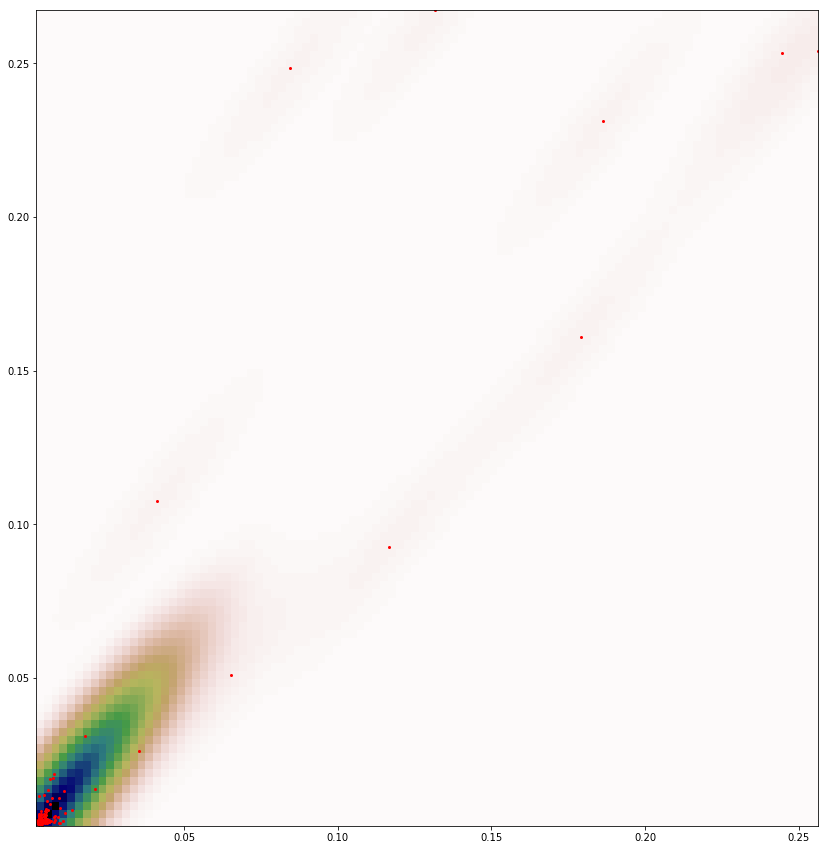

In [137]:
from scipy import stats

def show_kernel(data, kernel):
    xmin = np.min(data[0,:])
    xmax = np.max(data[0,:])
    ymin = np.min(data[1,:])
    ymax = np.max(data[1,:])
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)
    fig, ax = plt.subplots()
    ax.imshow(
        np.rot90(Z), cmap=plt.cm.gist_earth_r,
        extent=[xmin, xmax, ymin, ymax])
    ax.plot(data[0,:], data[1,:], 'r.', markersize=4)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

kernel = stats.gaussian_kde(g_data.transpose())
show_kernel(g_data.transpose(), kernel)



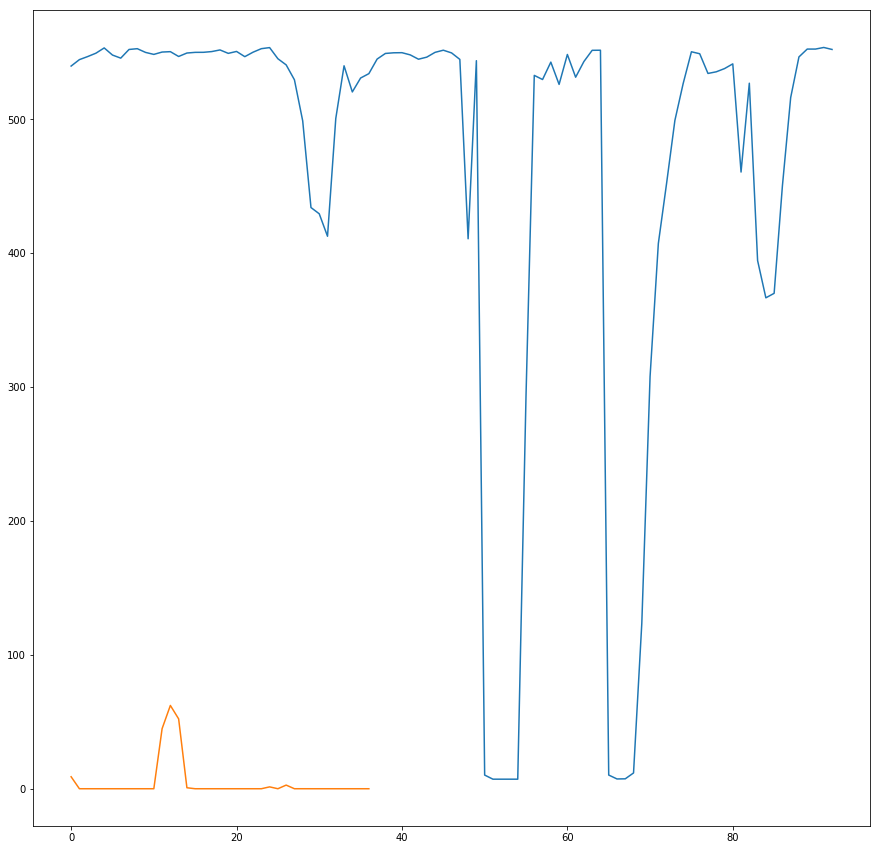

In [138]:
g_z = kernel.evaluate(g_data.transpose())
b_z = kernel.evaluate(b_data.transpose())

plt.plot(g_z)
plt.plot(b_z)
